In [2]:
"""
    References

    [1] N. K. Fontaine, R. Ryf, H. Chen, D. T. Neilson, K. Kim and J. Carpenter,
        “Laguerre-Gaussian mode sorter,” Nature Communications,
        vol. 10, no. 1865, pp. 1-7, 2019. 
"""

'\n    References\n\n    [1] N. K. Fontaine, R. Ryf, H. Chen, D. T. Neilson, K. Kim and J. Carpenter,\n        “Laguerre-Gaussian mode sorter,” Nature Communications,\n        vol. 10, no. 1865, pp. 1-7, 2019. \n'

In [3]:
"""
  Import Python Packages
"""
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import itertools
import math
import os
from tqdm import tqdm
import csv
import sklearn.metrics as sk
import seaborn as sns
import pandas

cuda_availability = torch.cuda.is_available()

In [4]:
"""
    Important Experimental Variables
"""
# optical variables
wavelength = 1565e-9                # wavelength (in meters)
pixel_size = 8e-6                   # pixel size (in meters)
nX = 200                            # 256 nuerons
nY = 200                            # 256 nuerons

# distances
distance_input = 0.03634            # distance from input to L1
disance_between_masks = 0.05        # distance between layers
distance_output = 0.03634           # distance from L5 to output

# training variables
num_epochs = 10                     # 10 iterations
learning_rate = 0.001           
training_batch_size = 128           # 2^8
validation_batch_size = 128         # 2^8
num_layers = 9

# image variables
input_size = 64                     # input image size
padding = (nX - input_size) // 2    # padding around the input image

# detector variables
detector_size = 5
detectors_per_row = [3, 4, 3]

save_path = "model2.9"
# CHANGE DATE AND VERSION EACH TIME
if not os.path.exists(save_path):
    os.makedirs(save_path)


In [5]:
"""
    Retrieve Transforms and MNIST Data
"""
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(
    "./mnist_data",
    train=True,
    transform=transform,
    download=True
)

val_dataset = torchvision.datasets.MNIST(
    "./mnist_data",
    train=False,
    transform=transform,
    download=True
)

# training dataset loader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=training_batch_size,
    shuffle=True
)

# validation dataset loader
validation_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=validation_batch_size,
    shuffle=False
)

In [6]:
"""
    Output Template (reference)
"""
# function to generate detector positions based on the output image size and detector size
def generateDetectorPositions():
    detector_positions = []
    row_height = input_size // 3

    for row in range(3):
        x_padding = (input_size - (3 * detector_size)) // 6
        x0 = row * row_height + x_padding + padding
        x1 = x0 + detector_size
        
        detectors_in_row = detectors_per_row[row]
        row_width = input_size // detectors_in_row
        
        for col in range(detectors_in_row):
            y_padding = (input_size - (detectors_in_row * detector_size)) // (detectors_in_row * 2)
            y0 = col * row_width + y_padding + padding
            y1 = y0 + detector_size
            detector_positions.append((x0, x1, y0, y1))
    
    return detector_positions

# generate detector positions
detector_positions = generateDetectorPositions()
print(detector_positions)

[(76, 81, 76, 81), (76, 81, 97, 102), (76, 81, 118, 123), (97, 102, 73, 78), (97, 102, 89, 94), (97, 102, 105, 110), (97, 102, 121, 126), (118, 123, 76, 81), (118, 123, 97, 102), (118, 123, 118, 123)]


In [7]:
"""
    Detector Layer
"""
# Function to generate output for detector layer
def detectorLayer(output):
    output_layer_list = []

    for x0, x1, y0, y1 in detector_positions:
        output_layer_list.append(
            ( output[:, x0:x1, y0:y1].sum(dim=(1, 2)) / output.sum(dim=(1,2)) ).unsqueeze(-1))

    return torch.cat(output_layer_list, dim = 1)

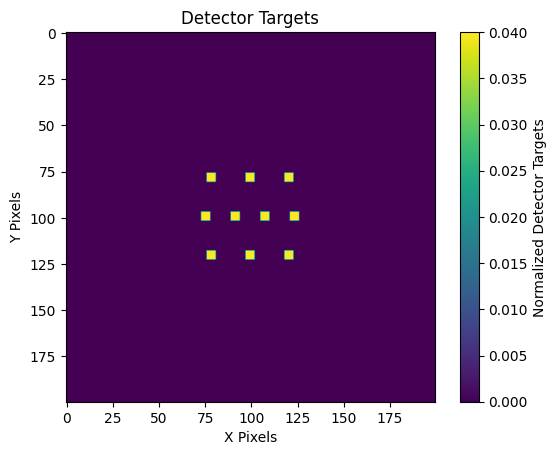

In [8]:
"""
    Generate Detector Targets
"""
detector_targets = torch.zeros((10, nX, nY), device = 'cpu', dtype = torch.double)

# generate detector labels normalized
for digit, detector_position in enumerate(detector_positions):
    x0, x1, y0, y1 = detector_position
    detector_region = detector_targets[digit, x0:x1, y0:y1]
    detector_region.fill_(1)
    detector_targets[digit] /= detector_region.sum()

# Plotting
plt.imshow(detector_targets.cpu().numpy().sum(axis=0))
plt.colorbar(label="Normalized Detector Targets")
plt.xlabel("X Pixels")
plt.ylabel("Y Pixels")
plt.title("Detector Targets")
plt.show()

In [9]:
"""
    References

    [1] N. K. Fontaine, R. Ryf, H. Chen, D. T. Neilson, K. Kim and J. Carpenter,
        “Laguerre-Gaussian mode sorter,” Nature Communications,
        vol. 10, no. 1865, pp. 1-7, 2019. 
"""

"""
    Base Class for Propagation
"""
class PropagationBase(torch.nn.Module):
    def __init__(self, distance):
        super(PropagationBase, self).__init__()
        self.distance = distance

    # Setup mask Cartesian co-ordinates where 0.5 pixel offset
    # makes the problem symmetric in x and y
    # Code Ref: [1] - MPLC_StartHere.m
    def setup_coordinates(self):
        # 1: Create X and Y tensors
        X = (torch.arange(1, nY + 1) - (nY / 2 + 0.5)) * pixel_size
        Y = (torch.arange(1, nX + 1) - (nX / 2 + 0.5)) * pixel_size

        # 2: Create meshgrid
        X, Y = torch.meshgrid(X, Y)
        
        return X, Y

    ### STAGE TWO ###
    # Transfer Function of Free Space
    # Code Ref: [1] - transferFunctionOfFreeSpace.m
    def setup_transfer_function(self, X, Y):
        # 1: Setup k-space coordinate system
        fs_x = nX / (torch.max(X) - torch.min(X))
        v_x = fs_x * (torch.arange(-nX / 2, nX / 2) / nX)

        fs_y = nY / (torch.max(Y) - torch.min(Y))
        v_y = fs_y * (torch.arange(-nY / 2, nY / 2) / nY)
        
        V_x, V_y = torch.meshgrid(v_x, v_y)

        # 2: Exponent for the transfer function of free-space
        tf_coef1 = -1j * 2 * np.pi * torch.sqrt(wavelength ** -2 - V_x ** 2 - V_y ** 2)

        # 3: Return transfer function of free-space for propagation distance dz
        return torch.exp(tf_coef1 * self.distance).to('cpu')

    ### STAGE THREE ###
    # Angular Spectrum - Free Space Propagation
    def forward(self, inputs):
        # 1: Convert real-space field to k-space field
        input_fft = torch.fft.fftshift(torch.fft.fft2(torch.fft.fftshift(inputs)))
        
        # 2: Apply the transfer function of free-space
        input_fft = input_fft * self.H0

        # 3: Convert k-space field back to real-space
        output = torch.fft.fftshift(torch.fft.ifft2(torch.fft.fftshift(input_fft)))

        return output.double()

In [10]:
"""
    Class to find Freespace-only propagation
"""
class FreespacePropagation(PropagationBase):
    def __init__(self, distance):
        super(FreespacePropagation, self).__init__(distance)
        X, Y = self.setup_coordinates()
        self.H0 = self.setup_transfer_function(X, Y)

In [11]:
"""
    Class to find Freespace and Diffraction propagation
"""
class FreespaceDiffractionLayer(PropagationBase):
    def __init__(self, distance):
        super(FreespaceDiffractionLayer, self).__init__(distance)
        X, Y = self.setup_coordinates()
        self.H0 = self.setup_transfer_function(X, Y)

In [14]:
"""
    Develop Network
"""
class ONN_Network(torch.nn.Module):
    def __init__(self):
        super(ONN_Network, self).__init__()

        # Initialize phase parameters
        self.phase = []
        for i in range(num_layers):
            phase_param = torch.nn.Parameter(torch.zeros((nX, nY), dtype=torch.float32))
            self.phase.append(phase_param)
            self.register_parameter("phase" + "_" + str(i), phase_param)

        # Initialize free space propagation layers
        self.first_free_space_propagation = FreespacePropagation(distance_input)

        self.all_diffractive_layers = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.all_diffractive_layers.append(FreespaceDiffractionLayer(disance_between_masks))

        self.last_free_space_propagation = FreespacePropagation(distance_output)

    def forward(self, inputs):
        forward = self.first_free_space_propagation(inputs)

        for index, layer in enumerate(self.all_diffractive_layers):
            propagation = layer(forward)
            phase_limit = 2 * np.pi * torch.sigmoid(self.phase[index])
            forward = propagation * torch.exp(1j * phase_limit)

        forward = self.last_free_space_propagation(forward)
        absolute_output = torch.abs(forward) ** 2

        return absolute_output, detectorLayer(absolute_output)

In [15]:
"""
    Helper Function
"""
def generateAndSaveClassificationMetrics(targets, predictions, epoch, metric_type):
    # Confusion Matrix
    confusion_matrix = sk.ConfusionMatrixDisplay.from_predictions(targets, predictions)
    confusion_matrix.figure_.suptitle("Confusion Matrix " + metric_type + "Epoch #" + str(epoch))
    confusion_matrix.plot().figure_.savefig(os.path.join(save_path, metric_type + "_confusion_matrix_" + str(epoch).zfill(3) + ".png"))

    # Classification Report
    classification_report = sk.classification_report(targets, predictions, output_dict=True)
    df = pandas.DataFrame(classification_report).transpose()
    df.to_csv(os.path.join(save_path, metric_type + "_classification_report_" + str(epoch).zfill(3) + ".csv")) 

In [16]:
"""
    Develop Classifier
"""
class Classifier ():
    def __init__(self,
               network,
               train_loader,
               validation_loader,
               learning_rate,
               num_epochs):
        self.network = network
        self.train_loader = train_loader
        self.validation_loader = validation_loader
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        self.optimiser = torch.optim.Adam(self.network.parameters(), lr=self.learning_rate)

        self.loss = torch.nn.MSELoss(reduction='sum').to('cpu')

        self.train_total_predictions = []
        self.train_total_targets = []
        self.train_total_loss = 0

        self.validate_total_predictions = []
        self.validate_total_targets = []
        self.validate_total_loss = 0

        print("Classifier Initialised with Network:\n", self.network)

    def train(self):
        for epoch in range(self.num_epochs):
            print("Epoch: #" + str(epoch))

            self.train_total_predictions = []
            self.train_total_targets = []
            self.train_total_loss = 0
            self.train_epoch(epoch)

            self.validate_total_predictions = []
            self.validate_total_targets = []
            self.validate_total_loss = 0
            self.validate(epoch)

            # save model
            torch.save(self.network, os.path.join(save_path, f"{epoch}_v1_model.pth"))

    def train_epoch(self, epoch):
        self.network.train()
        print("Training Epoch #" + str(epoch) + "...")
        correct = 0
        total = 0

        for data, target in tqdm(self.train_loader):

            data = data.to('cpu')
            image_data = torch.nn.functional.pad(torch.squeeze(data), pad=(padding, padding, padding, padding))

            targets = target.to('cpu')
            detector_target_labels = detector_targets[targets]                
            
            # zero the parameter gradients
            self.optimiser.zero_grad()

            # forward pass
            absolute_output, output_result = self.network(image_data)

            # get predictions
            _, predictions = torch.max(output_result.data, 1)
            correct += (predictions == targets).sum().item()
            total += targets.size(0)

            # calculate loss
            normalize_output = absolute_output / (absolute_output.sum(axis=(1, 2)))[:,None,None]
            training_loss = self.loss(normalize_output, detector_target_labels)

            # backwards pass
            training_loss.backward()

            # optimize
            self.optimiser.step()

            # calculate 
            self.train_total_loss += training_loss.item()
            self.train_total_predictions.extend(predictions.cpu().numpy())
            self.train_total_targets.extend(targets.cpu().numpy())
        
        self.train_total_loss /= len(self.train_loader)

        generateAndSaveClassificationMetrics(
            self.train_total_targets,
            self.train_total_predictions,
            epoch,
            "training"
        )

        print("Total Training Loss for Epoch #" + str(epoch) + ": " + str(self.train_total_loss))
        print("Total Training Accuracy for Epoch #" + str(epoch) + ": " + str(correct / total))
        print("--- --- --- --- --- --- --- --- --- --- --- --- --- --- ---")

    def validate(self, epoch):
        self.network.eval()
        print("Validating...")
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in tqdm(self.validation_loader):

                data = data.to('cpu')
                image_data = torch.nn.functional.pad(torch.squeeze(data), pad=(padding, padding, padding, padding))

                targets = target.to('cpu')
                detector_target_labels = detector_targets[targets]  

                # forward pass
                absolute_output, output_result = self.network(image_data)

                # get predictions
                _, predictions = torch.max(output_result.data, 1)
                correct += (predictions == targets).sum().item()
                total += targets.size(0)

                # calculate loss
                normalize_output = absolute_output / (absolute_output.sum(axis=(1, 2)))[:,None,None]
                validation_loss = self.loss(normalize_output, detector_target_labels)

                # calculate 
                self.validate_total_loss += validation_loss.item()
                self.validate_total_predictions.extend(predictions.cpu().numpy())
                self.validate_total_targets.extend(targets.cpu().numpy())

            self.validate_total_loss /= len(self.validation_loader)

            generateAndSaveClassificationMetrics(
                self.validate_total_targets,
                self.validate_total_predictions,
                epoch,
                "validation"
            )

            print("Total Validation Loss for Epoch #" + str(epoch) + ": " + str(self.validate_total_loss))
            print("Total Validation Accuracy for Epoch #" + str(epoch) + ": " + str(correct / total))
            print("--- --- --- --- --- --- --- --- --- --- --- --- --- --- ---")

In [ ]:
"""
    Train Model
"""
ONN = ONN_Network().to('cpu')

classifier = Classifier(
    ONN,
    train_loader,
    validation_loader,
    learning_rate,
    num_epochs
)

classifier.train()